In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"johndempsey","key":"05a4273e0947926ddb34667ed5c79a09"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 98% 793M/812M [00:08<00:00, 139MB/s]
100% 812M/812M [00:08<00:00, 105MB/s]


In [4]:
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory

In [5]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
conv_base  = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.tf",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 28s 244ms/step - loss: 16.8759 - accuracy: 0.8980 - val_loss: 4.7771 - val_accuracy: 0.9670
Epoch 2/50
63/63 [==============================] - 11s 174ms/step - loss: 7.9002 - accuracy: 0.9365 - val_loss: 7.8935 - val_accuracy: 0.9570
Epoch 3/50
63/63 [==============================] - 13s 198ms/step - loss: 5.7474 - accuracy: 0.9555 - val_loss: 4.0481 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 9s 144ms/step - loss: 4.8390 - accuracy: 0.9625 - val_loss: 5.3550 - val_accuracy: 0.9700
Epoch 5/50
63/63 [==============================] - 9s 145ms/step - loss: 3.8442 - accuracy: 0.9670 - val_loss: 5.9252 - val_accuracy: 0.9660
Epoch 6/50
63/63 [==============================] - 11s 177ms/step - loss: 3.1307 - accuracy: 0.9770 - val_loss: 4.4249 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 11s 179ms/step - loss: 3.0176 - accuracy: 0.9720 - val_loss: 5.1015 - val_accuracy: 0.9740


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.tf",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 210ms/step - loss: 0.4448 - accuracy: 0.9910 - val_loss: 1.3371 - val_accuracy: 0.9870
Epoch 2/30
63/63 [==============================] - 11s 169ms/step - loss: 0.5058 - accuracy: 0.9925 - val_loss: 2.1958 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 11s 166ms/step - loss: 0.5146 - accuracy: 0.9885 - val_loss: 1.9328 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 13s 210ms/step - loss: 0.5151 - accuracy: 0.9900 - val_loss: 0.7367 - val_accuracy: 0.9870
Epoch 5/30
63/63 [==============================] - 11s 164ms/step - loss: 0.4060 - accuracy: 0.9915 - val_loss: 1.1020 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 12s 194ms/step - loss: 0.1712 - accuracy: 0.9945 - val_loss: 1.1809 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 10s 163ms/step - loss: 0.2596 - accuracy: 0.9935 - val_loss: 1.2692 - val_accuracy: 0.9790

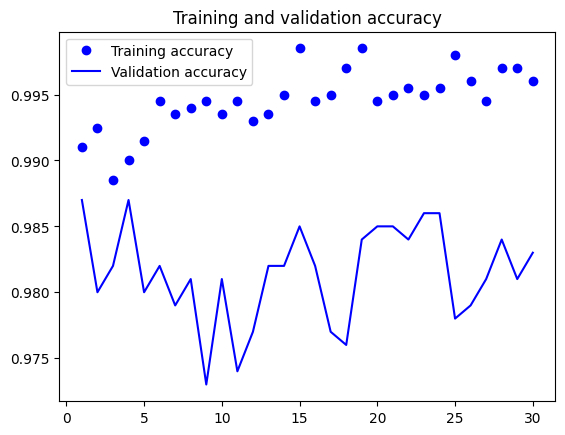

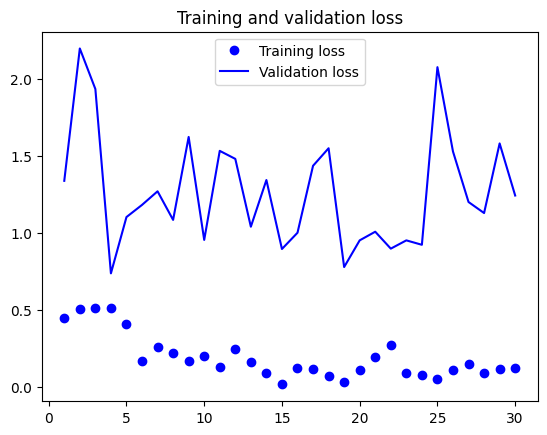

In [13]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
model = keras.models.load_model("fine_tuning.tf")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 2.0365 - accuracy: 0.9780
Test accuracy: 0.978
